In [350]:
%load_ext watermark

In [370]:
%watermark -v -m -p scipy,numpy,sklearn,pandas,matplotlib,seaborn,fatf

CPython 3.6.8
IPython 7.3.0

scipy 1.3.0
numpy 1.16.4
sklearn 0.21.1
pandas 0.25.0
matplotlib 3.1.0
seaborn 0.9.0
fatf 0.0.1-dev1

compiler   : GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [ ]:
import os
os.environ['FATF_SEED'] = '42'
%matplotlib inline

# FAT Forensics Use Cases #

In [1]:
import pandas as pd
import numpy as np

from IPython.display import display

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Prepare the Adult data set ##
Downlaod and pre-process the [adult data set](http://archive.ics.uci.edu/ml/datasets/Census+Income) (UCI Census Income) to use with out experiments. (The data set of choice in much algorithmic fairness research.)

In [1]:
! wget http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2019-08-20 13:43:36--  http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M   714KB/s    in 6.1s    

2019-08-20 13:43:43 (637 KB/s) - ‘adult.data’ saved [3974305/3974305]



In [2]:
census_names = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income'
]

df = pd.read_csv('adult.data', names=census_names, skipinitialspace=True)

# Remove missing values
df = df[df != '?']

# Get feature mapping to get purely numerical data array
features_unique = {
    'workclass': df['workclass'].unique(),
    'education': np.sort(df['education'].unique()),
    'marital-status': np.sort(df['marital-status'].unique()),
    'occupation': df['occupation'].unique(),
    'relationship': np.sort(df['relationship'].unique()),
    'race': np.sort(df['race'].unique()),
    'sex': np.sort(df['sex'].unique()),
    'native-country': df['native-country'].unique(),
    'income': np.sort(df['income'].unique())
}

df_unmapped = df.copy()


map_i_s = {}
map_s_i = {}
for feature_name in features_unique:
    map_i_s[feature_name] = dict()
    map_s_i[feature_name] = dict()
    for i, value in enumerate(features_unique[feature_name]):
        map_i_s[feature_name][i] = value
        map_s_i[feature_name][value] = i
        
# Map the categorical features to numbers
for feature_name in map_s_i:
    df[feature_name] = df[feature_name].map(map_s_i[feature_name])

# Split the array into X and y
data_array = df.drop('income', axis=1).values
ground_truth = df['income'].values

/Users/kacper/.pyenv/versions/3.6.8/envs/fatf36/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [7]:
# Train a classifier
clf = LogisticRegression(solver='lbfgs')
# clf = SVC()
clf.fit(data_array, ground_truth)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Grouping for Fairness, Accountability and Transparency ##
Let's group the data set based on `race` feature.

In [43]:
race_index = census_names.index('race')

In [44]:
import fatf.utils.data.tools as fatf_data_tools

19-Aug-20 16:37:28 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


### Grouping for group-based data transparency ###

In [49]:
race_grouping = fatf_data_tools.group_by_column(data_array, race_index, treat_as_categorical=True)

In [50]:
# race_grouping
race_grouping[1]

['(0,)', '(1,)', '(2,)', '(3,)', '(4,)']

In [51]:
features_unique['race']

array(['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other',
       'White'], dtype=object)

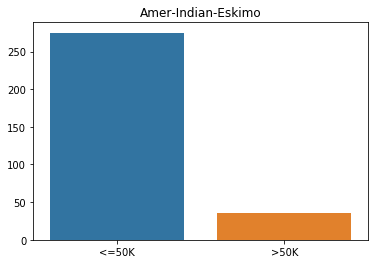

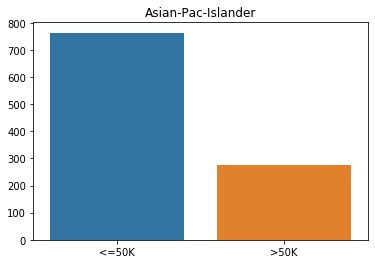

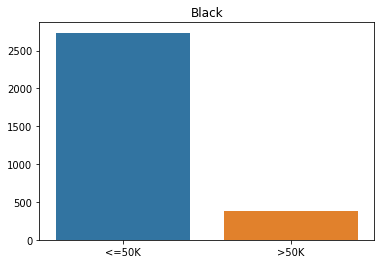

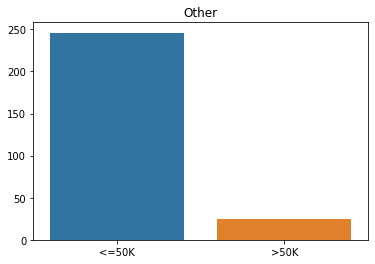

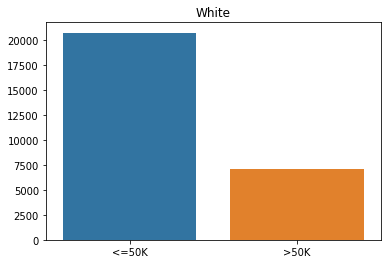

In [157]:
for i, race in enumerate(features_unique['race']):
    desc = fatf_describe_data.describe_categorical_array(
        ground_truth[race_grouping[0][i]])
    
    sns.barplot(x=features_unique['income'], y=desc['unique_counts'])
    plt.title(race)
    plt.show()

### Grouping for group-based fairness ###

In [ ]:
import fatf.utils.metrics.tools as fatf_metric_tools
import fatf.utils.metrics.metrics as fatf_performance_metrics

In [ ]:
adult_predictions = clf.predict(data_array)

In [166]:
confusion_matrix = fatf_metric_tools.get_confusion_matrix(ground_truth, adult_predictions)

In [167]:
fatf_performance_metrics.accuracy(confusion_matrix)

0.7957372316575044

In [135]:
import fatf.fairness.models.measures as fatf_fairness_models

In [242]:
race_cm = fatf_metric_tools.confusion_matrix_per_subgroup_indexed(
    race_grouping[0],
    ground_truth,
    adult_predictions,
    labels=np.unique(ground_truth).tolist())

In [278]:
race_equal_accuracy = fatf_fairness_models.equal_accuracy(race_cm, tolerance=0.14)

In [279]:
race_equal_accuracy

array([[False, False, False, False, False],
       [False, False, False,  True, False],
       [False, False, False, False, False],
       [False,  True, False, False, False],
       [False, False, False, False, False]])

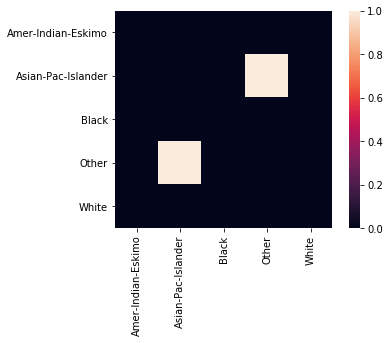

In [280]:
sns.heatmap(race_equal_accuracy, square=True, xticklabels=features_unique['race'], yticklabels=features_unique['race'], vmin=0, vmax=1)

In [281]:
race_equal_opportunity = fatf_fairness_models.equal_opportunity(race_cm, tolerance=0.14)

In [282]:
race_equal_opportunity

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

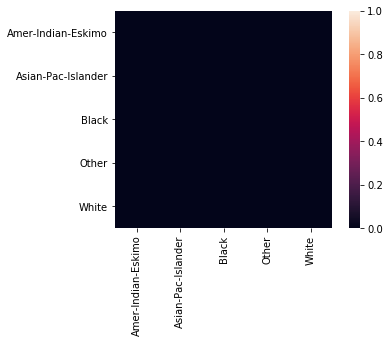

In [283]:
sns.heatmap(race_equal_opportunity, square=True, xticklabels=features_unique['race'], yticklabels=features_unique['race'], vmin=0, vmax=1)

In [284]:
race_demographic_parity = fatf_fairness_models.demographic_parity(race_cm, tolerance=0.14)

In [285]:
race_demographic_parity

array([[False, False, False, False, False],
       [False, False, False,  True, False],
       [False, False, False, False, False],
       [False,  True, False, False,  True],
       [False, False, False,  True, False]])

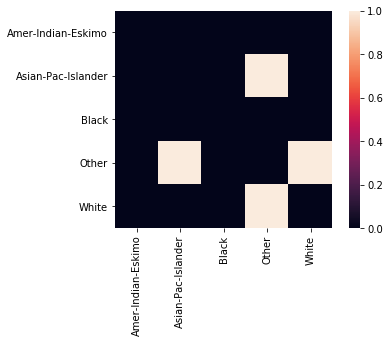

In [286]:
sns.heatmap(race_demographic_parity, square=True, xticklabels=features_unique['race'], yticklabels=features_unique['race'], vmin=0, vmax=1)

### Grouping for group-based performance disparity ###

In [291]:
import fatf.utils.metrics.subgroup_metrics as subgroup_metrics
import fatf.accountability.models.measures as fatf_accountability_models_measures

In [290]:
race_accuracy = subgroup_metrics.apply_metric(race_cm, metric='accuracy')

In [311]:
race_accuracy_bias = fatf_accountability_models_measures.systematic_performance_bias_grid(race_accuracy, threshold=0.83)

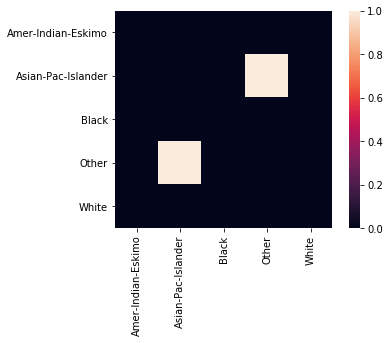

In [312]:
sns.heatmap(race_accuracy_bias, square=True, xticklabels=features_unique['race'], yticklabels=features_unique['race'], vmin=0, vmax=1)

In [321]:
race_tnr = subgroup_metrics.apply_metric(race_cm, metric='true negative rate')

In [322]:
race_tnr_bias = fatf_accountability_models_measures.systematic_performance_bias_grid(race_tnr, threshold=0.83)

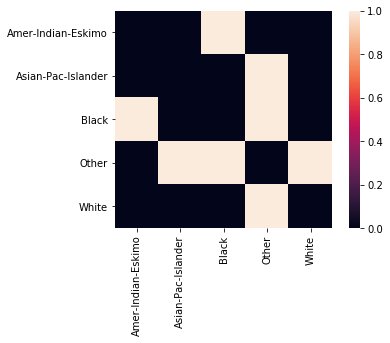

In [323]:
sns.heatmap(race_tnr_bias, square=True, xticklabels=features_unique['race'], yticklabels=features_unique['race'], vmin=0, vmax=1)

## Data Density for Robustness and Feasible Counterfactuals ##

### Assess robustness of a prediction with density ###

In [39]:
import fatf.utils.data.density as fatf_density
import scipy

In [40]:
adult_density = fatf_density.DensityCheck(data_array[:10000,:], distance_function=scipy.spatial.distance.euclidean)

In [3]:
data_point_index_dense_1 = 42
data_point_index_dense_2 = 142
data_point_index_sparse_1 = 5369  # 414
data_point_index_sparse_2 = 8258  # 1597

In [358]:
for i in [data_point_index_dense_1, data_point_index_dense_2, data_point_index_sparse_1, data_point_index_sparse_2]:
    x = data_array[i, :]
    print('Data point index: {}'.format(i))
    print('Density score: {}'.format(adult_density.score_data_point(x)))
    print('Griound truth: {}'.format(ground_truth[i]))
    print('Prediction: {}'.format(clf.predict([x])[0]))
    print('\n-----------------------\n')

Data point index: 42
Density score: 0.0002593754294177954
Griound truth: 0
Prediction: 0

-----------------------

Data point index: 142
Density score: 0.000839312364934433
Griound truth: 0
Prediction: 0

-----------------------

Data point index: 5369
Density score: 0.8576374693996145
Griound truth: 0
Prediction: 0

-----------------------

Data point index: 8258
Density score: 0.9903562910580268
Griound truth: 1
Prediction: 0

-----------------------



In [362]:
df_unmapped.iloc[data_point_index_sparse_2]

age                               35
workclass                    Private
fnlwgt                       1226583
education                  Bachelors
education-num                     13
marital-status    Married-civ-spouse
occupation                     Sales
relationship                 Husband
race                           White
sex                             Male
capital-gain                       0
capital-loss                       0
hours-per-week                    52
native-country         United-States
income                          >50K
Name: 8258, dtype: object

In [364]:
df_unmapped.fnlwgt.describe()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

In [367]:
scipy.stats.percentileofscore(df_unmapped.fnlwgt.values, 1226583)

99.98771536500722

### Assess feasibility of a counterfactual with density ###

In [4]:
import fatf.transparency.predictions.counterfactuals as fatf_cf

19-Aug-21 14:31:51 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [5]:
categorical_features = [i for i, f_name in enumerate(census_names) if f_name in features_unique and f_name != 'income']

In [31]:
cf_explainer = fatf_cf.CounterfactualExplainer(
    model=clf,
    dataset=data_array,
    categorical_indices=categorical_features,
    default_numerical_step_size=100,
    step_sizes=\
    {census_names.index('age'): 5,
    census_names.index('fnlwgt'): 100,
    census_names.index('education-num'): 5,
    census_names.index('capital-gain'): 1000,
    census_names.index('capital-loss'): 1000,
    census_names.index('hours-per-week'): 2})

In [32]:
cf_explanations = cf_explainer.explain_instance(data_array[data_point_index_sparse_2, :])

In [33]:
cf_explanations

(array([[     35,       2, 1226583, ...,    4000,      52,       0],
        [     35,       2, 1226583, ...,       0,      52,       0],
        [     35,       2, 1226583, ...,       0,      52,       0],
        ...,
        [     35,       2, 1226583, ...,       0,      52,       0],
        [     37,       2, 1226583, ...,       0,      52,       0],
        [     35,       2,  430985, ...,    4000,      52,       0]]),
 array([ 21000,  25000,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25

In [35]:
print(fatf_cf.textualise_counterfactuals(data_array[data_point_index_sparse_2, :], cf_explanations[0], 0, cf_explanations[1], cf_explanations[2]))

Instance (of class *0*):
[     35       2 1226583       9      13       2       5       0       4
       1       0       0      52       0]

Feature names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Counterfactual instance (of class *1*):
Distance: 21000
    feature *10*: *0* -> *17000*
    feature *11*: *0* -> *4000*

Counterfactual instance (of class *1*):
Distance: 25000
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *1*: *2* -> *1*
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *3*: *9* -> *0*
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *3*: *9* -> *1*
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *3*: *9* -> *2*
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *3*: *9* -> *3*
    feature *10*: *0* -> *25

In [41]:
adult_density.score_data_point(cf_explanations[0][1])

0.9935077619756921

In [42]:
adult_density.score_data_point(cf_explanations[0][-1])

0.012813950672755132

### Counterfactual fairness -- bias uncovered by explainability ###

In [43]:
cf_fairness = fatf_cf.CounterfactualExplainer(
    model=clf,
    dataset=data_array,
    categorical_indices=categorical_features,
    default_numerical_step_size=100,
    step_sizes=\
    {census_names.index('age'): 5,
    census_names.index('fnlwgt'): 100,
    census_names.index('education-num'): 5,
    census_names.index('capital-gain'): 1000,
    census_names.index('capital-loss'): 1000,
    census_names.index('hours-per-week'): 2},
    counterfactual_feature_indices=[0, 5, 7, 8, 9, 13])

In [44]:
cf_fair = cf_fairness.explain_instance(data_array[data_point_index_sparse_2, :])

In [45]:
cf_fair

(array([], shape=(0, 0), dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

## Local Surrogates Based on Linear and Logical Models ##

In [ ]:
import fatf
import fatf.transparency.sklearn.blimey as ftsb
import fatf.utils.data.augmentation as fuda
import fatf.utils.data.discretization as fudd
import fatf.utils.kernels as fuk
import fatf.utils.distances as fud
import fatf.transparency.sklearn.linear_model as ftslm
import fatf.utils.transparency.model_comparison as futmc

from fatf.transparency.sklearn.feature_choice import lasso_path
from fatf.utils.data.augmentation import NormalSampling, TruncatedNormal, GrowingSpheres, Mixup, LocalSurrogate

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.datasets
import sklearn.metrics

import csv
import scipy.stats

In [ ]:
def normalise_datasets(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(dataset)
    #scaler = StandardScaler(with_mean=True).fit(dataset)
    return scaler.transform(dataset)

# Load datasets
# 1/2 Moons
moons, moons_label = sklearn.datasets.make_moons(
    n_samples=5000, noise=0.25, random_state=4)
moons = normalise_datasets(moons)

In [ ]:
global_model = RandomForestClassifier(n_estimators=200)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(moons, moons_label, test_size=0.2)
global_model.fit(train, labels_train)
global_acc = sklearn.metrics.accuracy_score(labels_test, global_model.predict(test))
print('Global Accuracy: %.3f' % global_acc)

Global Accuracy: 0.932


In [ ]:
point = np.array([0.25, 0.50]) # To generate explanation for
global_class = 1

samples_number_local = 3000

kernel = fuk.exponential_kernel
normal_aug = NormalSampling(train)

tree = DecisionTreeRegressor(max_depth=3, random_state=42)
ridge = Ridge(alpha=1, fit_intercept=True, random_state=42)

# Ridge
fatf.setup_random_seed()
sampled_data = normal_aug.sample(point, samples_number=samples_number_local)
prediction = global_model.predict_proba(sampled_data)[:, global_class]
distance_normal = fud.euclidean_array_distance(
    np.expand_dims(point, 0), sampled_data).flatten()
weights_normal = kernel(distance_normal, width=0.75*np.sqrt(sampled_data.shape[1])) # Default LIME width
ridge.fit(sampled_data, prediction, sample_weight=weights_normal)

# Tree
fatf.setup_random_seed()
sampled_data = normal_aug.sample(point, samples_number=samples_number_local)
prediction = global_model.predict_proba(sampled_data)[:, global_class]
tree.fit(sampled_data, prediction, sample_weight=np.ones_like(prediction))

19-Aug-20 21:26:20 fatf         INFO     Seeding RNGs with 42.
19-Aug-20 21:26:20 fatf         INFO     Seeding RNGs with 42.


DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [ ]:
# for plotting
padding=0.15
res=0.01

#max and min values of x and y of the dataset
x_min,x_max=test[:,0].min(), test[:,0].max()
y_min,y_max=test[:,1].min(), test[:,1].max()

#range of x's and y's
x_range=x_max-x_min
y_range=y_max-y_min

#add padding to the ranges
x_min -= x_range * padding
y_min -= y_range * padding
x_max += x_range * padding
y_max += y_range * padding
xx,yy=np.meshgrid(np.arange(x_min,x_max,res),np.arange(y_min,y_max,res))

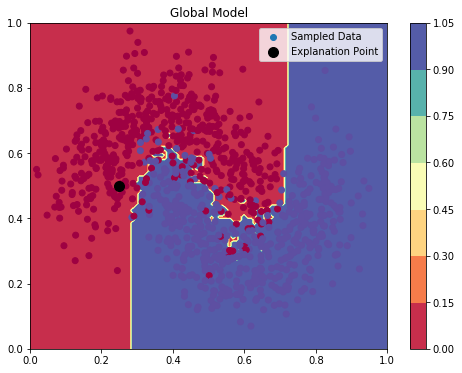

In [ ]:
# plot global, local with ridge, local with decision tree
Z = global_model.predict(np.c_[xx.ravel(), yy.ravel()])   
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.title('Global Model')
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, vmax=1.0, vim=0.0)
cbar = plt.colorbar(cs)
plt.scatter(test[:, 0], test[:, 1], c=labels_test, cmap=plt.cm.Spectral, label='Sampled Data')
plt.scatter(point[0], point[1], c='k', s=100, label='Explanation Point')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()

### Linear model surrogate ###

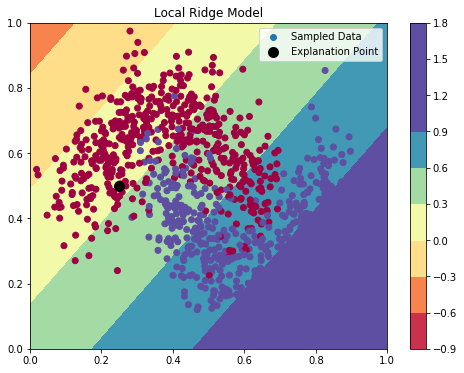

In [ ]:
Z = ridge.predict(np.c_[xx.ravel(), yy.ravel()])   
Z =
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.title('Local Ridge Model')
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, vmax=1.0, vim=0.0)
cbar = plt.colorbar(cs)
plt.scatter(test[:, 0], test[:, 1], c=labels_test, cmap=plt.cm.Spectral, label='Sampled Data')
plt.scatter(point[0], point[1], c='k', s=100, label='Explanation Point')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()

### Tree surrogate ###

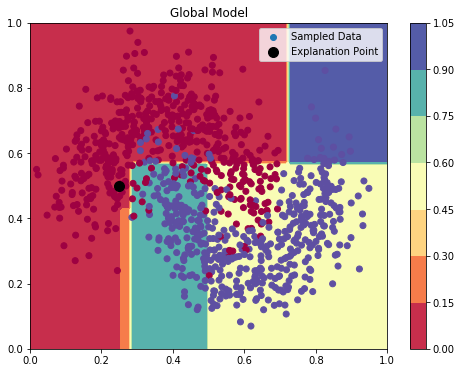

In [ ]:
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])   
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.title('Global Model')
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, vmax=1.0, vim=0.0)
cbar = plt.colorbar(cs)
plt.scatter(test[:, 0], test[:, 1], c=labels_test, cmap=plt.cm.Spectral, label='Sampled Data')
plt.scatter(point[0], point[1], c='k', s=100, label='Explanation Point')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()